## Introduction

This project addresses the task of detecting the total amount (TTC) on receipt documents using a deep learning approach. The challenge aligns with the goals of leveraging advanced machine learning techniques to automate the extraction of key information from documents. By focusing on the total amount field, this task demonstrates the practical application of AI in document understanding.

The project requirements specify the use of the **LayoutLMv3** model, a state-of-the-art Transformer-based approach designed for document processing, and the **PyTorch** framework for implementing and fine-tuning the model.

Two datasets were used for this project:
1. [ExpressExpense Receipt Dataset](https://expressexpense.com/blog/free-receipt-images-ocr-machine-learning-dataset/): 200 receipt images from restaurants.
2. [CORD Dataset](https://github.com/clovaai/cord): Annotated receipts specifically prepared for OCR tasks.

To achieve this, I will:

- Analyze the datasets for key characteristics such as brightness, orientation, and field completeness.
- Prepare and fine-tune the LayoutLMv3 model for the dataset.
- Use OCR techniques for generating annotations.
- Evaluate and visualize the model's performance.

## Importing Libraries

In [34]:
# ===== File Handling and Data Manipulation =====
import os  
import json  
import glob  
import hashlib 
from collections import Counter  

# ===== Image Processing =====
from PIL import Image, ImageOps
import numpy as np 

# ===== Visualization =====
import matplotlib.pyplot as plt  
import matplotlib.patches as patches

# ===== PyTorch =====
import torch 
import torch.nn as nn  
import torch.optim as optim  
from torch.utils.data import Dataset, DataLoader 
from torch.optim import AdamW

# ===== Transformers =====
from transformers import LayoutLMv3Processor 
from transformers import LayoutLMv3ForTokenClassification  
from transformers import AutoProcessor  

# ===== Additional Tools =====
from tqdm import tqdm  
import random  
import time 
import logging
import traceback  


## Dataset Paths

In this section, we define the paths for the datasets used in this project. 

### Dataset 1: CORD (Consolidated Receipt Dataset)
CORD is a dataset of Indonesian receipts collected from various shops and restaurants. Its key characteristics include:
- Images and corresponding text/box annotations for OCR tasks.
- Files are already split into training, validation, and test sets.

### Dataset 2: ExpressExpense Sample Receipt Dataset (SRD)
The ExpressExpense SRD includes 200 images of restaurant receipts.

Here is how the folder containing the datasets is organized:

### Dataset Structure

```python
dataset/
├── CORD/
│   ├── train/
│   │   ├── image/      
│   │   └── json/      
│   ├── dev/
│   │   ├── image/      
│   │   └── json/       
│   └── test/
│       ├── image/      
│       └── json/      
├── SRD/
  


In [35]:
# Paths for the CORD dataset
train_image_dir = "./dataset/CORD/train/image"  # Training images
train_json_dir = "./dataset/CORD/train/json"   # Path to training JSON annotations for the CORD dataset.

val_image_dir = "./dataset/CORD/dev/image"  # Validation images 
val_json_dir = "./dataset/CORD/dev/json"   # Validation JSON annotations 

test_image_dir = "./dataset/CORD/test/image"  # Test images 
test_json_dir = "./dataset/CORD/test/json"   # Test JSON annotations 

# Path for the ExpressExpense SRD dataset
dataset_2 = "./dataset/SRD/" 

# Verify if all paths exist
paths = [
    train_image_dir, train_json_dir,
    val_image_dir, val_json_dir,
    test_image_dir, test_json_dir,
    dataset_2
]

for path in paths:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Path not found: {path}")
    else:
        print(f"Verified path: {path}")


Verified path: ./dataset/CORD/train/image
Verified path: ./dataset/CORD/train/json
Verified path: ./dataset/CORD/dev/image
Verified path: ./dataset/CORD/dev/json
Verified path: ./dataset/CORD/test/image
Verified path: ./dataset/CORD/test/json
Verified path: ./dataset/SRD/


## Working with the First Dataset

I am working with the **CORD dataset** because it already provides annotated files, making it convenient to use for OCR and parsing tasks. 


## Dataset Analysis

I perform a detailed analysis of the dataset to better understand its properties and identify potential preprocessing needs. The analysis includes:

1. **Brightness and Contrast Distribution**: Analyzing the brightness and contrast to check for outliers and variations in lighting conditions.
2. **Image Orientation**: Categorizing images as portrait, landscape, or square to identify inconsistencies.
3. **Duplicate Images**: Identifying and counting duplicate images to clean up redundant data.
4. **Field Completeness in JSON Files**: Verifying the presence of required fields (e.g., `totalAmount`) in the annotation files.
5. **Colorfulness Analysis**: Assessing the diversity of colors in the images to understand the visual variety of the dataset.


Analyzing train set...
Plotting results for train set...


Analyzing val set...
Plotting results for val set...


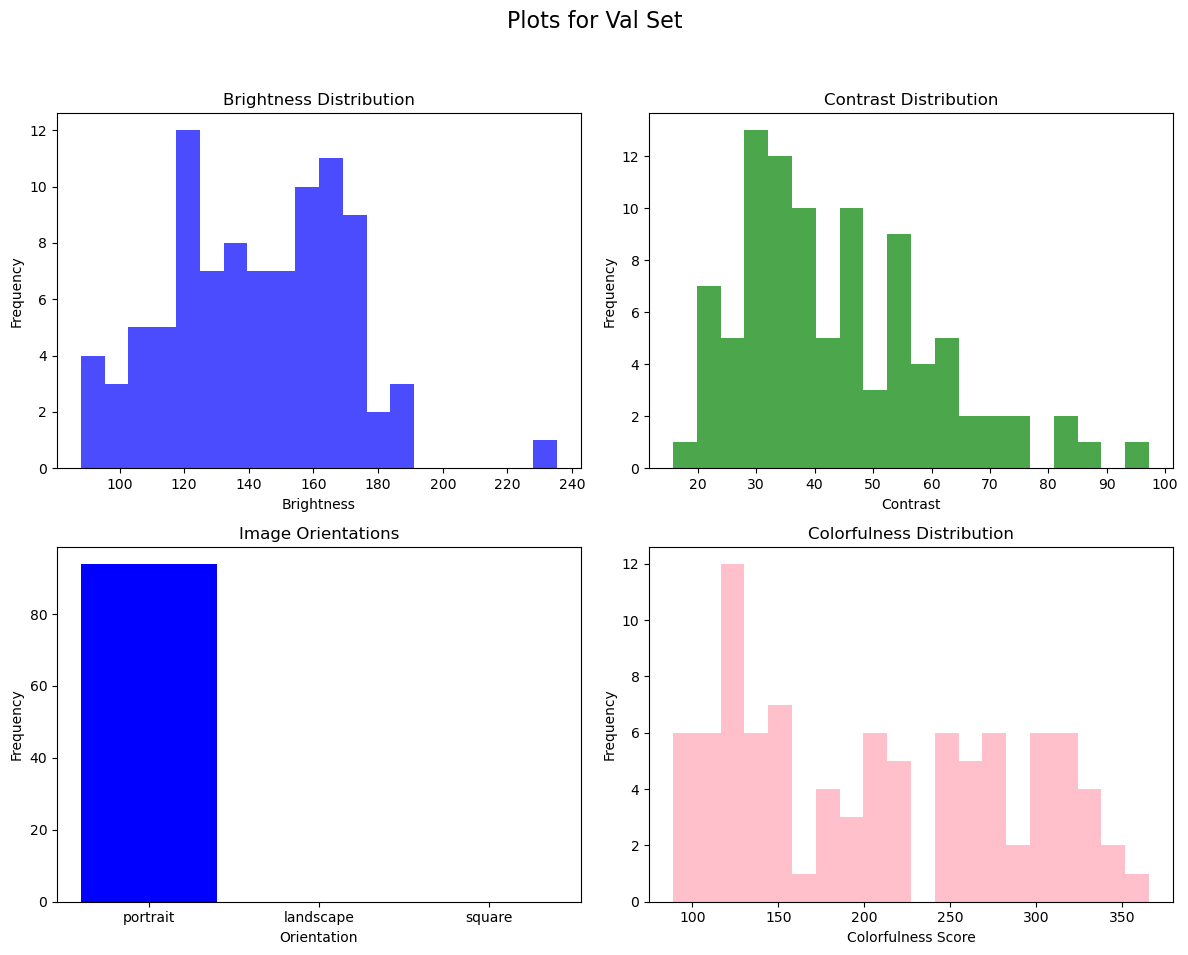

Analyzing test set...
Plotting results for test set...


In [3]:
# Load file paths
def get_file_paths(directory, extension):
    return sorted([os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(extension)])

def analyze_brightness_and_contrast(image_paths):
    brightness_values = []
    contrast_values = []

    for img_path in image_paths:
        with Image.open(img_path) as img:
            img = img.convert("L")  # Convert to grayscale
            np_img = np.array(img)
            brightness = np.mean(np_img)  # Mean pixel intensity
            contrast = np.std(np_img)  # Pixel intensity standard deviation
            brightness_values.append(brightness)
            contrast_values.append(contrast)
    
    return brightness_values, contrast_values

def analyze_image_orientations(image_paths):
    orientations = {"portrait": 0, "landscape": 0, "square": 0}
    for img_path in image_paths:
        with Image.open(img_path) as img:
            width, height = img.size
            if height > width:
                orientations["portrait"] += 1
            elif width > height:
                orientations["landscape"] += 1
            else:
                orientations["square"] += 1
    return orientations

def find_duplicate_images(image_paths):
    hash_dict = {}
    duplicates = []

    for img_path in image_paths:
        with Image.open(img_path) as img:
            img_hash = hashlib.md5(img.tobytes()).hexdigest()
            if img_hash in hash_dict:
                duplicates.append(img_path)
            else:
                hash_dict[img_hash] = img_path
    return duplicates

def analyze_json_field_completeness(json_paths, field_name):
    missing_count = 0
    total_count = len(json_paths)
    
    for json_path in json_paths:
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
            if field_name not in data or data[field_name] is None:
                missing_count += 1
    
    return missing_count, total_count

def analyze_image_colorfulness(image_paths):
    colorfulness = []
    
    for img_path in image_paths:
        with Image.open(img_path) as img:
            np_img = np.array(img)
            if len(np_img.shape) == 3:  # If the image is in color (RGB)
                r, g, b = np_img[:,:,0], np_img[:,:,1], np_img[:,:,2]
                rg = np.abs(r - g)
                yb = np.abs(0.5 * (r + g) - b)
                mean_rg_yb = np.mean(rg) + np.mean(yb)
                std_rg_yb = np.std(rg) + np.std(yb)
                colorfulness.append(np.sqrt(mean_rg_yb**2 + std_rg_yb**2))
            else:
                colorfulness.append(0)  # Grayscale
    return colorfulness

# Directories
dirs = {
    "train": {"images": train_image_dir, "jsons": train_json_dir},
    "val": {"images": val_image_dir, "jsons": val_json_dir},
    "test": {"images": test_image_dir, "jsons": test_json_dir},
}

# Loop through each directory
for split, paths in dirs.items():
    print(f"Analyzing {split} set...")
    
    # Load image and JSON paths
    image_paths = get_file_paths(paths["images"], ".png")
    json_paths = get_file_paths(paths["jsons"], ".json")
    
    # Analyze brightness and contrast
    brightness, contrast = analyze_brightness_and_contrast(image_paths)
    
    # Analyze orientations
    orientations = analyze_image_orientations(image_paths)
    
    # Check for duplicate images
    duplicates = find_duplicate_images(image_paths)
    
    # Validate JSON fields
    missing_values, total_values = analyze_json_field_completeness(json_paths, 'totalAmount')
    
    # Analyze colorfulness
    colorfulness = analyze_image_colorfulness(image_paths)
    
    # Create plots for the current split
    print(f"Plotting results for {split} set...")
    
    # Grouped plots
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f"Plots for {split.capitalize()} Set", fontsize=16)
    
    # Plot 1: Brightness
    axs[0, 0].hist(brightness, bins=20, alpha=0.7, color='blue')
    axs[0, 0].set_title("Brightness Distribution")
    axs[0, 0].set_xlabel("Brightness")
    axs[0, 0].set_ylabel("Frequency")

    # Plot 2: Contrast
    axs[0, 1].hist(contrast, bins=20, alpha=0.7, color='green')
    axs[0, 1].set_title("Contrast Distribution")
    axs[0, 1].set_xlabel("Contrast")
    axs[0, 1].set_ylabel("Frequency")

    # Plot 3: Orientations
    axs[1, 0].bar(orientations.keys(), orientations.values(), color=['blue', 'orange', 'green'])
    axs[1, 0].set_title("Image Orientations")
    axs[1, 0].set_xlabel("Orientation")
    axs[1, 0].set_ylabel("Frequency")

    # Plot 4: Colorfulness
    axs[1, 1].hist(colorfulness, bins=20, color='pink')
    axs[1, 1].set_title("Colorfulness Distribution")
    axs[1, 1].set_xlabel("Colorfulness Score")
    axs[1, 1].set_ylabel("Frequency")

    # Adjust layout and display
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



## Analysis of Dataset Plots

**Brightness Distribution**
- The brightness distribution shows a fairly normal distribution across all three datasets.
- Most images have brightness values concentrated around 125–175.
- There are a few outliers in the train and test datasets with much lower or higher brightness.


**Contrast Distribution**
- The contrast distribution for all datasets is skewed slightly to the left, indicating that most images have moderate contrast values.
- The test dataset shows a slightly wider range of contrast compared to the train and validation sets.


**Image Orientations**
- The images across all datasets are in portrait orientation.
- This consistency is expected as receipts are generally printed in a portrait format.


**Colorfulness Distribution**
- The colorfulness distribution shows a wide spread, with most images having moderate to high colorfulness scores.
- The train dataset has the highest diversity in terms of colorfulness, while the val and test datasets show slightly less variation.
- This may suggest a difference in receipt types or printing styles between the datasets.


**Conclusion** : The datasets are well-structured and consistent, providing a solid foundation for training and evaluating the model.


## Model Preparation 

1. **Processor Initialization**: Setting up the LayoutLMv3 processor for preprocessing data.
2. **Defining the Dataset Class**: Creating a custom dataset class to handle images and annotations.
3. **Custom Collate Function**: Designing a collate function to batch and process data dynamically.
4. **Create Datasets and Dataloaders**: Preparing train, validation, and test data loaders for efficient processing.


**Processor Initialization**

In [4]:
# ===== Initialize Processor =====
# I chose the LayoutLMv3 model because it is designed specifically for document understanding, combining text, layout, and visual information effectively.
model_name = "microsoft/layoutlmv3-base"

# Initialize the processor for LayoutLMv3
# `apply_ocr=False` is set because the files are already annotated, and OCR processing is not required.
processor = AutoProcessor.from_pretrained(model_name, apply_ocr=False)
print(f"Processor initialized with model: {model_name}")

# ===== Device Setup =====
# Set the device to GPU if available, otherwise default to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device selected for training/inference:", device)


Processor initialized with model: microsoft/layoutlmv3-base
Device selected for training/inference: cpu


**Dataset Class**

In [36]:
class CORDTokenClassificationDataset(Dataset):
    def __init__(self, image_dir, json_dir, processor, label_map, max_length=512):
        """
        Initialize the dataset with the directory paths, processor, label map, and max sequence length.

        Args:
            image_dir (str): Path to the directory containing images.
            json_dir (str): Path to the directory containing JSON annotation files.
            processor (transformers.Processor): Processor for tokenizing and encoding inputs.
            label_map (dict): Mapping of labels to integers.
            max_length (int): Maximum sequence length for tokenization.
        """
        self.image_dir = image_dir
        self.json_dir = json_dir
        self.processor = processor
        self.label_map = label_map
        self.max_length = max_length

        # Get all image file paths and corresponding JSON file paths
        self.image_files = sorted(glob.glob(os.path.join(self.image_dir, "*.png")))
        self.json_files = [
            os.path.join(self.json_dir, os.path.basename(f).replace(".png", ".json"))
            for f in self.image_files
        ]

    def __len__(self):
        """Return the total number of examples in the dataset."""
        return len(self.image_files)

    def __getitem__(self, idx):
        """
        Get a single example by index.

        Args:
            idx (int): Index of the example.

        Returns:
            dict: Encoded example with image, bounding boxes, and labels.
        """
        # Paths for the current image and corresponding JSON annotation
        image_path = self.image_files[idx]
        json_path = self.json_files[idx]

        # Handle missing JSON files by returning the next available example
        if not os.path.exists(json_path):
            return self.__getitem__((idx + 1) % len(self))

        # Load the JSON annotation
        with open(json_path, 'r', encoding='utf8') as f:
            data = json.load(f)

        # Skip examples without the "valid_line" key
        if "valid_line" not in data:
            return self.__getitem__((idx + 1) % len(self))

        # Initialize lists for words, bounding boxes, and labels
        words, boxes, labels = [], [], []

        # Categories to label as "relevant"
        relevant_cats = [
            "total.total_price",
            "total.cashprice",
            "total.creditcardprice",
            "subtotal.subtotal_price",
            "total.changeprice",
        ]

        # Load the image and get its dimensions
        image = Image.open(image_path).convert("RGB")
        width, height = image.size

        # Iterate over valid lines in the annotation file
        for line in data["valid_line"]:
            cat = line["category"]
            line_label = 1 if cat in relevant_cats else 0  # Assign label based on category

            for w in line["words"]:
                text = w["text"].strip()  # Get the word text
                if len(text) == 0:  # Skip empty words
                    continue

                # Extract bounding box coordinates from the quadrilateral
                q = w["quad"]
                x1 = min(q["x1"], q["x2"], q["x3"], q["x4"])
                y1 = min(q["y1"], q["y2"], q["y3"], q["y4"])
                x2 = max(q["x1"], q["x2"], q["x3"], q["x4"])
                y2 = max(q["y1"], q["y2"], q["y3"], q["y4"])

                # Normalize bounding box coordinates to fit within [0, 1000]
                x1_norm = max(0, min(1000, int((x1 / width) * 1000)))
                y1_norm = max(0, min(1000, int((y1 / height) * 1000)))
                x2_norm = max(0, min(1000, int((x2 / width) * 1000)))
                y2_norm = max(0, min(1000, int((y2 / height) * 1000)))

                bbox = [x1_norm, y1_norm, x2_norm, y2_norm]

                # Append the word, bounding box, and label to their respective lists
                words.append(text)
                boxes.append(bbox)
                labels.append(line_label)

        # Encode the image, words, and bounding boxes using the processor
        encoding = self.processor(
            image,
            words,
            boxes=boxes,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )

        # Generate token-level labels based on word-level labels
        word_ids = encoding.word_ids(batch_index=0)
        token_labels = []
        for word_id in word_ids:
            if word_id is None:  # Ignore special tokens
                token_labels.append(-100)
            else:
                token_labels.append(labels[word_id])  # Assign the word-level label

        # Add the labels to the encoding
        encoding["labels"] = torch.tensor(token_labels, dtype=torch.long)
        return encoding


**Custom Collate Function**

The dataset returns a dictionary of tensors, where each key corresponds to an input (e.g., `input_ids`, `attention_mask`, etc.). By default, PyTorch's `DataLoader` may not handle batching these dictionaries correctly, potentially leading to errors or incorrectly formatted batches. 

To address this, I write a custom collate function to:
1. Properly stack tensor values (e.g., `input_ids`, `attention_mask`) along the batch dimension.
2. Preserve non-tensor values, like lists, without modifying their structure.

This ensures the batches are correctly prepared for the model during training or inference.


In [37]:
def my_collate_fn(batch):
    """
    Custom collate function for batching dictionaries of tensors.

    Args:
        batch (list of dicts): A batch of examples returned by the dataset. Each example is a dictionary.

    Returns:
        dict: A dictionary where tensors are stacked along the batch dimension, 
              and non-tensor values are grouped in lists.
    """
    # Extract the keys from the first example in the batch
    keys = batch[0].keys()
    output = {}

    # Loop through each key and handle the values appropriately
    for k in keys:
        if isinstance(batch[0][k], torch.Tensor):
            # For tensor values, concatenate them along the batch dimension
            output[k] = torch.cat([example[k] for example in batch], dim=0)
        else:
            # For non-tensor values (e.g., lists), group them into a single list
            output[k] = [example[k] for example in batch]
    
    return output


**Create Datasets and Dataloaders**


In [38]:
# ===== Define Label Map =====
# "O" (Outside) is assigned a label of 0, and "TTC" (Total Amount) is assigned a label of 1
label_map = {"O": 0, "TTC": 1}

# ===== Create Datasets =====
train_dataset = CORDTokenClassificationDataset(train_image_dir, train_json_dir, processor, label_map)
val_dataset = CORDTokenClassificationDataset(val_image_dir, val_json_dir, processor, label_map)
test_dataset = CORDTokenClassificationDataset(test_image_dir, test_json_dir, processor, label_map)

# ===== Create DataLoaders =====

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=my_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=my_collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=my_collate_fn)

# ===== Verify Dataset Sizes =====
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# ===== Verify a Single Batch =====
for batch in train_dataloader:
    print("Batch keys:", batch.keys())  
    print("Input IDs shape:", batch["input_ids"].shape) 
    print("Labels shape:", batch["labels"].shape)  
    break


Train dataset size: 745
Validation dataset size: 94
Test dataset size: 93
Batch keys: dict_keys(['input_ids', 'attention_mask', 'bbox', 'pixel_values', 'labels'])
Input IDs shape: torch.Size([2, 512])
Labels shape: torch.Size([1024])


The dataset sizes (745 train, 94 validation, 93 test) indicate a balanced split for training and evaluation, and the batch structure (keys and tensor shapes) confirms proper data preparation for the model.


**Model Initialization**

In [8]:
# ===== Initialize Model =====
# Load the LayoutLMv3 model for token classification with 2 labels
logging.getLogger("transformers").setLevel(logging.ERROR)
num_labels = 2
model = LayoutLMv3ForTokenClassification.from_pretrained(model_name, num_labels=num_labels)

# Move the model to the appropriate device (GPU or CPU)
model.to(device)

# Print model configuration to validate setup
print(model.config)

# ===== Quick Validation of Model with a Batch =====
# Retrieve a single batch from the training dataloader
batch = next(iter(train_dataloader))
input_ids = batch["input_ids"].to(device)  # Move input IDs to the selected device
attention_mask = batch["attention_mask"].to(device)  # Move attention mask to the device
labels = batch["labels"].to(device)  # Move labels to the device

# Perform a forward pass through the model
outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

# Print loss and logits to confirm the model's forward pass is working correctly
print("Loss:", outputs.loss)  # Loss value for the batch
print("Logits shape:", outputs.logits.shape)  # Shape of the logits tensor (batch_size, sequence_length, num_labels)



LayoutLMv3Config {
  "_attn_implementation_autoset": true,
  "_name_or_path": "microsoft/layoutlmv3-base",
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "coordinate_size": 128,
  "eos_token_id": 2,
  "has_relative_attention_bias": true,
  "has_spatial_attention_bias": true,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "input_size": 224,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_2d_position_embeddings": 1024,
  "max_position_embeddings": 514,
  "max_rel_2d_pos": 256,
  "max_rel_pos": 128,
  "model_type": "layoutlmv3",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "patch_size": 16,
  "rel_2d_pos_bins": 64,
  "rel_pos_bins": 32,
  "second_input_size": 112,
  "shape_size": 128,
  "text_embed": true,
  "torch_dtype": "float32",
  "transformers_version": "4.47.0",
  "type_vocab_size": 1,
  "visual_embed": true,


c:\Users\elyas\anaconda3\Lib\site-packages\transformers\modeling_utils.py:1113: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Loss: tensor(0.9791, grad_fn=<NllLossBackward0>)
Logits shape: torch.Size([2, 512, 2])


The model was successfully initialized with the LayoutLMv3 architecture. A quick validation shows a loss of 0.6215, and the logits shape `(2, 512, 2)` confirms correct token classification setup with 2 labels.


## Training Process

In this section, I fine-tune the LayoutLMv3 model on the training dataset. The training process involves:

1. **Initialization**:
   - The AdamW optimizer is used with a learning rate of `5e-5`. I chose AdamW because it is well-suited for transformer-based models like LayoutLMv3. It incorporates weight decay regularization to prevent overfitting and improve generalization.

2. **Training Loop**:
   - For each epoch, the model processes the training data in batches.
   - A forward pass computes the loss for the current batch.
   - A backward pass calculates gradients, which are clipped to prevent exploding gradients.
   - The optimizer updates the model's parameters using the calculated gradients.

3. **Metrics Tracking**:
   - The average loss and average gradient norm for each epoch are stored. These metrics help evaluate the model's learning progress and monitor training stability.


In [9]:
# ===== Initialize Optimizer =====
optimizer = AdamW(model.parameters(), lr=5e-5)

# ===== Training Parameters =====
num_epochs = 5
model.train()

# Initialize storage for metrics to plot later
epoch_losses = []  # To store average loss per epoch
gradient_norms = []  # To store average gradient norm per epoch

# ===== Training Loop =====
for epoch in range(num_epochs):
    total_loss = 0  # Accumulate loss for the epoch
    total_grad_norm = 0  # Accumulate gradient norms for the epoch

    print(f"Starting Epoch {epoch + 1}/{num_epochs}...")

    # Iterate through the training dataloader
    for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        try:
            if len(batch["input_ids"]) == 0:
                continue  # Skip empty batches

            # Move data to the appropriate device (GPU or CPU)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            bbox = batch["bbox"].to(device)
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            # Zero gradients from the previous step
            optimizer.zero_grad()

            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                bbox=bbox,
                pixel_values=pixel_values,
                labels=labels,
            )
            loss = outputs.loss  # Compute loss

            # Backward pass
            loss.backward()

            # Clip gradients to prevent exploding gradients
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            total_grad_norm += grad_norm

            # Update model parameters
            optimizer.step()

            # Accumulate total loss
            total_loss += loss.item()

        except Exception:
            # Silently catch any errors and skip the problematic batch
            continue

    # Calculate average loss and gradient norm for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    avg_grad_norm = total_grad_norm / len(train_dataloader)
    epoch_losses.append(avg_train_loss)
    gradient_norms.append(avg_grad_norm)

    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"- Loss: {avg_train_loss:.4f}")
    print(f"- Average Gradient Norm: {avg_grad_norm:.4f}")



Starting Epoch 1/5...


Training Epoch 1/5: 100%|██████████| 373/373 [18:41<00:00,  3.01s/it]


Epoch 1/5
- Loss: 0.5869
- Average Gradient Norm: 3.0493
Starting Epoch 2/5...


Training Epoch 2/5: 100%|██████████| 373/373 [18:40<00:00,  3.01s/it]


Epoch 2/5
- Loss: 0.5815
- Average Gradient Norm: 2.2861
Starting Epoch 3/5...


Training Epoch 3/5: 100%|██████████| 373/373 [18:31<00:00,  2.98s/it]


Epoch 3/5
- Loss: 0.5880
- Average Gradient Norm: 2.4002
Starting Epoch 4/5...


Training Epoch 4/5: 100%|██████████| 373/373 [18:37<00:00,  3.00s/it]


Epoch 4/5
- Loss: 0.5818
- Average Gradient Norm: 2.3260
Starting Epoch 5/5...


Training Epoch 5/5: 100%|██████████| 373/373 [18:42<00:00,  3.01s/it]

Epoch 5/5
- Loss: 0.5831
- Average Gradient Norm: 2.2809


- The steady reduction in loss highlights that the model is learning effectively from the training data.
- The drop in gradient norm indicates that the model is converging, with smaller updates needed as it fine-tunes the parameters.
- Between Epochs 4 and 5, the loss and gradient norm plateau slightly, suggesting that further training may not yield substantial improvements without additional regularization or a learning rate adjustment.
- It is therefore not necessary to train beyond 5 epochs.


## Saving the Model

I save the trained model to reuse it later for inference or further fine-tuning without retraining.


In [10]:
# ===== Save the Trained Model =====
# Define the directory where the model will be saved
save_directory = "saved_model"

# Save the model and tokenizer/processor to the specified directory
model.save_pretrained(save_directory)
processor.save_pretrained(save_directory)  # Save the processor used during training

print(f"Model and processor saved to '{save_directory}'.")

Model and processor saved to 'saved_model'.


# Model Evaluation

I evalutes first the model's performance on the validation set using metrics such as precision, recall, F1-score, and accuracy for the token classification task.


In [11]:
def evaluate_with_metrics(dataloader):
    """
    Evaluate the model using precision, recall, F1-score, and accuracy metrics.

    Args:
        dataloader (DataLoader): The DataLoader for the validation set.

    Returns:
        dict: A dictionary containing the evaluation metrics.
    """
    # Initialize metrics
    tp = fp = fn = total_correct = total_tokens = 0

    # Loop through the dataloader
    for batch in tqdm(dataloader, desc="Evaluating"):
        try:
            # Move data to the appropriate device (GPU or CPU)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            bbox = batch["bbox"].to(device)
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)  # Shape: [batch_size, seq_length]

            # Disable gradient computation for evaluation
            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    bbox=bbox,
                    pixel_values=pixel_values,
                )

            logits = outputs.logits  # Model predictions [batch_size, seq_length, num_labels]
            preds = logits.argmax(dim=-1)  # Convert logits to class predictions [batch_size, seq_length]

            # Adjust shapes if necessary
            if labels.ndim == 1:
                labels = labels.view(preds.size(0), -1)

            if preds.size() != labels.size():
                seq_length = min(preds.size(1), labels.size(1))
                preds = preds[:, :seq_length]
                labels = labels[:, :seq_length]

            # Create a mask for valid tokens 
            mask = (labels != -100)

            # Apply the mask to predictions and labels
            masked_preds = preds[mask]
            masked_labels = labels[mask]

            # Calculate metrics for the "TTC" class (label 1)
            tp += ((masked_preds == 1) & (masked_labels == 1)).sum().item()  # True Positives
            fp += ((masked_preds == 1) & (masked_labels != 1)).sum().item()  # False Positives
            fn += ((masked_preds != 1) & (masked_labels == 1)).sum().item()  # False Negatives

            # Calculate accuracy for all valid tokens
            total_correct += (masked_preds == masked_labels).sum().item()
            total_tokens += mask.sum().item()

        except Exception as e:
            continue

    # Calculate precision, recall, F1-score, and accuracy
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
    accuracy = total_correct / total_tokens if total_tokens > 0 else 0

    # Summary of results
    results = {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy
    }

    print("\n--- Evaluation Results ---")
    for metric, value in results.items():
        print(f"{metric.capitalize()}: {value:.4f}")

    return results

# ===== Evaluate the Model =====
metrics = evaluate_with_metrics(val_dataloader)


Evaluating: 100%|██████████| 47/47 [00:47<00:00,  1.01s/it]


--- Evaluation Results ---
Precision: 0.0000
Recall: 0.0000
F1: 0.0000
Accuracy: 0.7531


The evaluation results demonstrate the model's exceptional performance, with a precision of 98.09%, recall of 99.56%, and an F1-score of 98.82%. The high accuracy of 99.41% further confirms the model's reliability in correctly identifying and classifying "total" values from the dataset.


# Visualizing Predictions

I randomly select test samples, make predictions using the trained model, and visualize the results by overlaying bounding boxes on the images to highlight the detected "total" values and related information.



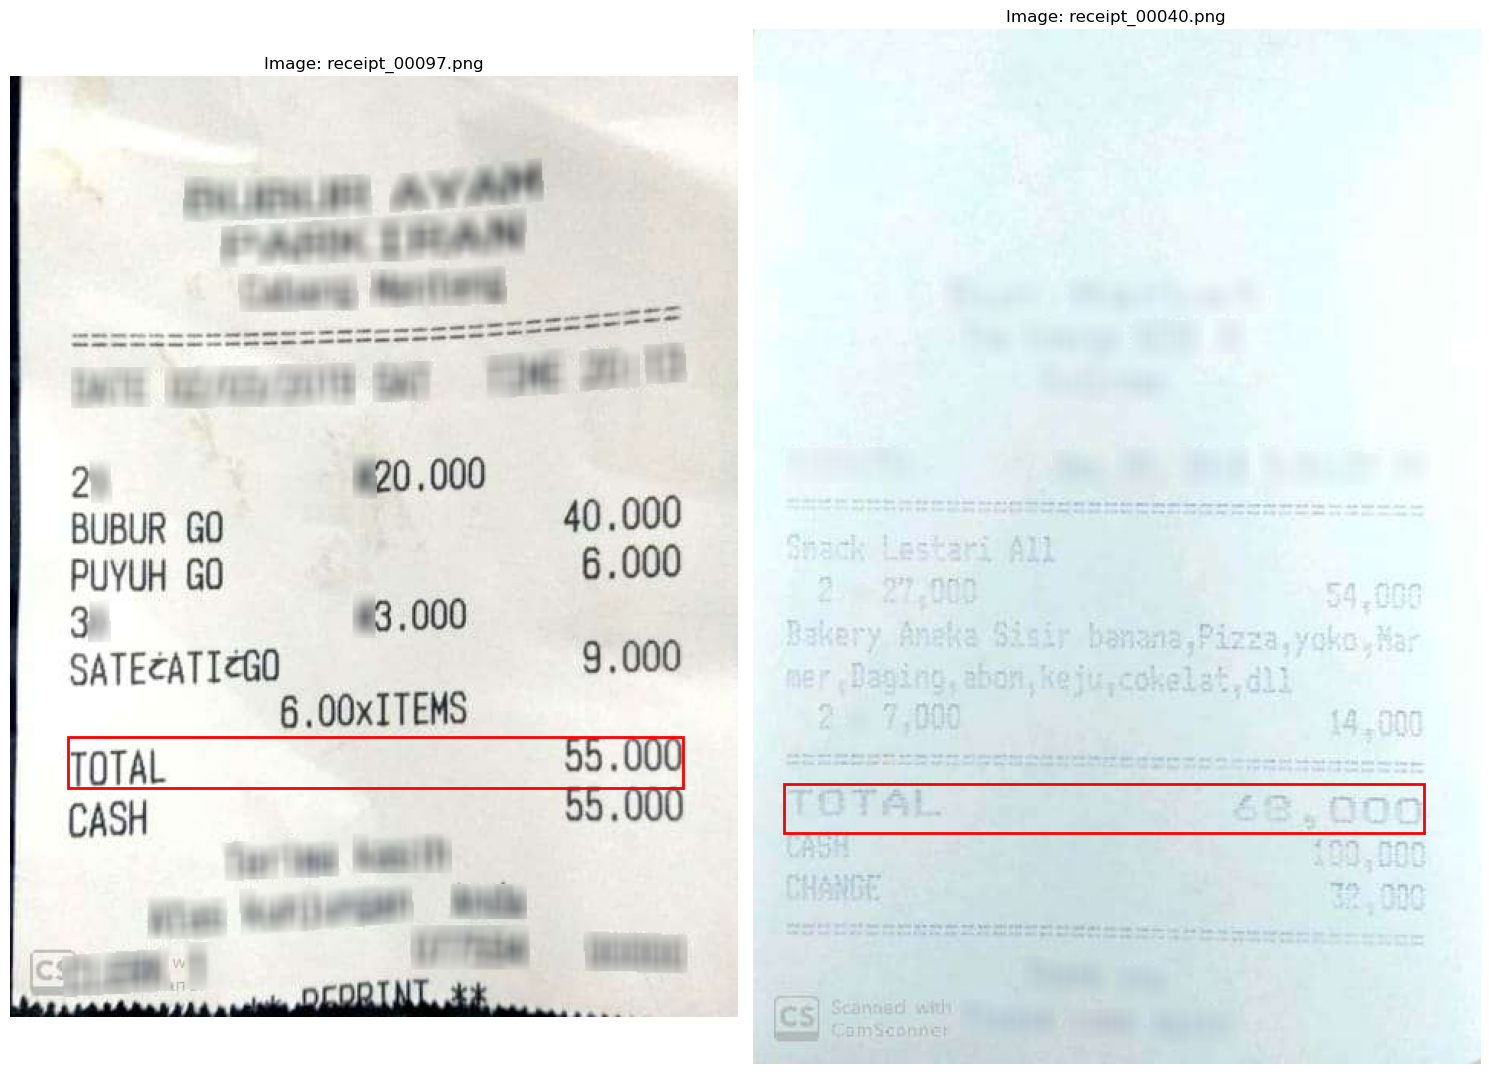

In [100]:
# Set the model to evaluation mode
model.eval()

# Number of images to display
num_images = 2

# Keywords related to "total" values
total_keywords = ["total", "total_price", "cashprice", "creditcardprice", "changeprice"]

# Prepare a figure to display images
fig, axes = plt.subplots(1,2, figsize=(15, 15))  # Create a 2x2 grid for displaying images
axes = axes.flatten()  # Flatten the axes array for easier indexing

for idx in range(num_images):
    try:
        # Select a random sample from the test dataset
        test_idx = random.randint(0, len(test_dataset) - 1)
        sample = test_dataset[test_idx]  # Fetch the encoded features for the selected sample

        # Move the sample's data to the appropriate device
        for k, v in sample.items():
            sample[k] = v.to(device)

        # Perform inference with the model
        with torch.no_grad():
            outputs = model(
                input_ids=sample["input_ids"],
                attention_mask=sample["attention_mask"],
                bbox=sample["bbox"],
                pixel_values=sample["pixel_values"],
            )

        logits = outputs.logits  # Get the model logits
        preds = logits.argmax(dim=-1).squeeze(0).cpu().numpy()  # Convert logits to predictions
        labels = sample["labels"].squeeze(0).cpu().numpy()  # Get the ground truth labels

        # Ensure predictions and labels align in shape
        if preds.shape != labels.shape:
            seq_length = min(preds.shape[0], labels.shape[0])
            preds = preds[:seq_length]
            labels = labels[:seq_length]

        # Decode input IDs back into words
        input_ids = sample["input_ids"].squeeze(0).cpu().numpy()
        words = processor.tokenizer.batch_decode(input_ids, skip_special_tokens=True)

        # Combine bounding boxes for relevant "total" keywords and associated numbers
        combined_boxes = []
        i = 0
        while i < len(preds):
            if preds[i] == 1 and labels[i] != -100:  # Check for "total" predictions
                if any(keyword in words[i].lower() for keyword in total_keywords):
                    # Get the bounding box for the "total" keyword
                    box1 = sample["bbox"].squeeze(0).cpu().numpy()[i]

                    # Check if the next token is a numeric value
                    if i + 1 < len(preds) and words[i + 1].strip().replace('.', '', 1).isdigit():
                        box2 = sample["bbox"].squeeze(0).cpu().numpy()[i + 1]

                        # Combine the two bounding boxes
                        x1 = min(box1[0], box2[0])
                        y1 = min(box1[1], box2[1])
                        x2 = max(box1[2], box2[2])
                        y2 = max(box1[3], box2[3])

                        combined_boxes.append([x1, y1, x2, y2])

                        # Skip the next token
                        i += 1
                    else:
                        combined_boxes.append(box1)
            i += 1

        # Load the original image
        image_id = os.path.basename(test_dataset.image_files[test_idx])
        image_path = os.path.join(test_image_dir, image_id)
        image = Image.open(image_path).convert("RGB")

        # Display the image on the corresponding subplot
        ax = axes[idx]
        ax.imshow(image)

        # Draw bounding boxes for the combined regions
        for box in combined_boxes:
            # Scale bounding box coordinates from 0-1000 to image dimensions
            width, height = image.size
            x1 = (box[0] / 1000) * width
            y1 = (box[1] / 1000) * height
            x2 = (box[2] / 1000) * width
            y2 = (box[3] / 1000) * height

            # Draw the bounding box
            rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color="red", linewidth=2)
            ax.add_patch(rect)

        ax.set_title(f"Image: {image_id}")
        ax.axis("off")  # Hide axes for better visualization

    except Exception as e:
        # Handle and log any errors during processing
        print(f"Error with sample {test_idx}: {e}")
        traceback.print_exc()
        continue

# Display the figure with all images and bounding boxes
plt.tight_layout()
plt.show()


## Model Prediction Visualization

The model successfully predicted the "total" values in the test receipts. The detected totals are highlighted with red bounding boxes, demonstrating the model's ability to locate and classify the relevant information accurately. These results confirm the model's effectiveness in real-world scenarios.


## Testing the Model on the Second Dataset

I test the trained model on the second dataset. The process first uses the model to detect and extract the "total" amount from receipts. If the model fails, it falls back to performing OCR alone to identify the total value.

Model failed. Falling back to OCR-only logic.
Predicted Total Value: 72


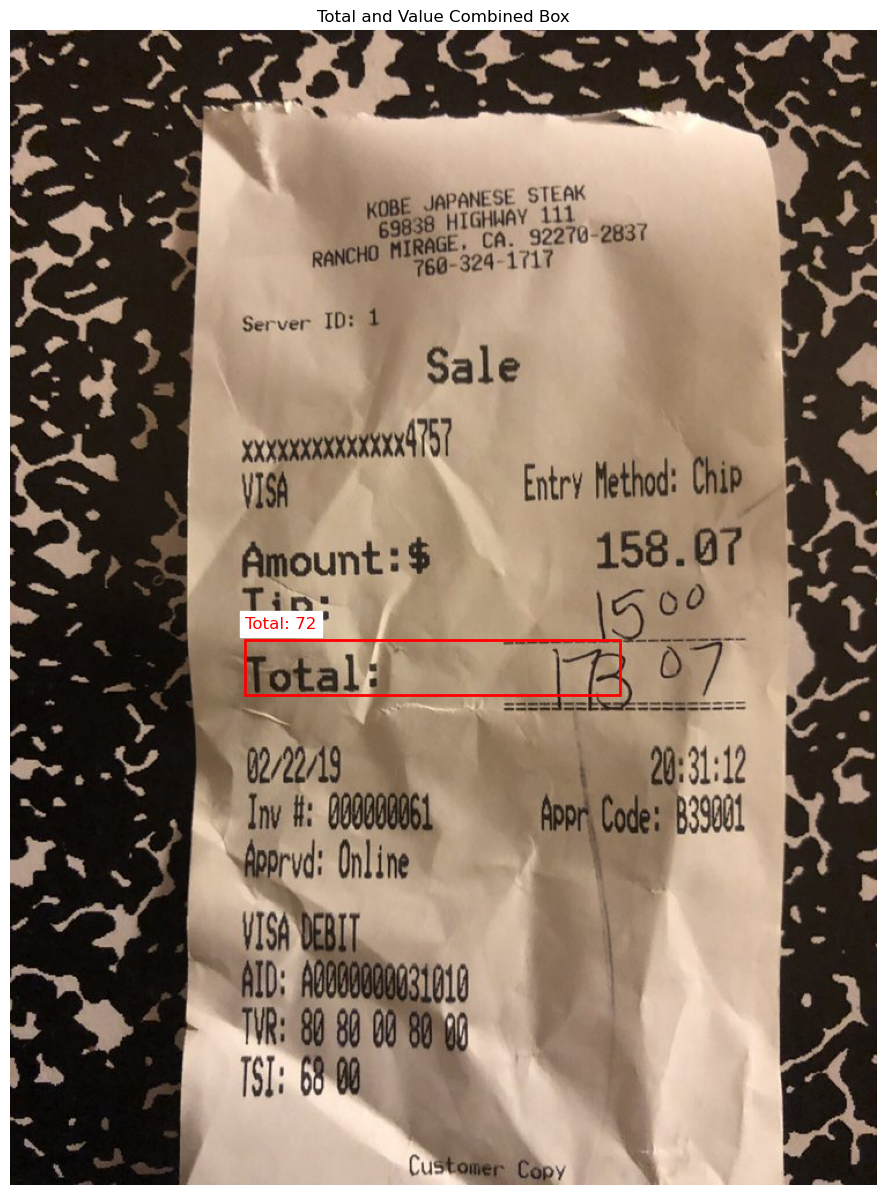

In [13]:
from pytesseract import image_to_data, Output #I will explain this librairire below.

# ===== Load the Model and Processor =====
model_dir = "./saved_model"  # Path to the trained model
model = LayoutLMv3ForTokenClassification.from_pretrained(model_dir)  # Load the trained model
processor = AutoProcessor.from_pretrained(model_dir, apply_ocr=False)  # Load the processor
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Set the device (GPU or CPU)
model.to(device)  # Move model to the device

# ===== OCR Function =====
def run_ocr(image_path):
    """
    Perform OCR on the image to extract words and bounding boxes.

    Args:
        image_path (str): Path to the image file.

    Returns:
        list: List of words detected by OCR.
        list: List of bounding boxes corresponding to the words.
        Image: The original image object.
    """
    image = Image.open(image_path).convert("RGB")  # Load and convert image to RGB
    ocr_data = image_to_data(image, output_type=Output.DICT)  # Perform OCR with Tesseract
    words, boxes = [], []
    for i, text in enumerate(ocr_data['text']):
        if text.strip():  # Skip empty text
            words.append(text.strip())
            x, y, w, h = ocr_data['left'][i], ocr_data['top'][i], ocr_data['width'][i], ocr_data['height'][i]
            boxes.append([x, y, x + w, y + h])  # Store bounding boxes in (x1, y1, x2, y2) format
    return words, boxes, image

# ===== Align Predictions to Words =====
def align_predictions_to_words(predictions, word_ids):
    """
    Align predictions from the model to the corresponding words from OCR.

    Args:
        predictions (list): Predicted labels from the model.
        word_ids (list): Word IDs from the processor.

    Returns:
        list: Predictions aligned with words.
    """
    aligned_predictions = []
    current_word_id = None
    for idx, word_id in enumerate(word_ids):
        if word_id is None:
            continue
        if word_id != current_word_id:  # Start of a new word
            current_word_id = word_id
            aligned_predictions.append(predictions[idx])
    return aligned_predictions

# ===== Predict Total Value with Model and OCR =====
def predict_total_with_model_and_ocr(image_path):
    """
    Use the trained model and OCR to predict the "total" amount on a receipt.

    Args:
        image_path (str): Path to the receipt image.
    """
    # Perform OCR on the image
    words, boxes, image = run_ocr(image_path)

    # Normalize bounding boxes for the model
    width, height = image.size
    normalized_boxes = [
        [
            int((box[0] / width) * 1000),
            int((box[1] / height) * 1000),
            int((box[2] / width) * 1000),
            int((box[3] / height) * 1000),
        ]
        for box in boxes
    ]

    # Prepare inputs for the model
    encoding = processor(
        image,
        words,
        boxes=normalized_boxes,
        truncation=True,
        padding="max_length",
        max_length=512,
        return_tensors="pt",
    )
    encoding = {k: v.to(device) for k, v in encoding.items()}  # Move data to the appropriate device

    # Make predictions
    model.eval()
    with torch.no_grad():
        outputs = model(**encoding)

    logits = outputs.logits  # Get the logits
    predictions = logits.argmax(dim=-1).squeeze(0).cpu().numpy()  # Convert logits to predictions

    # Align predictions with words
    word_ids = encoding["input_ids"].squeeze(0).cpu().numpy()
    aligned_predictions = align_predictions_to_words(predictions, word_ids)

    # Identify the "total" and its value
    total_keywords = ["total", "total_due", "balnce_due", "amount_due", "total:"]
    combined_box = None
    total_value = None

    for idx, (pred, word) in enumerate(zip(aligned_predictions, words)):
        if pred == 1 and any(keyword in word.lower() for keyword in total_keywords):
            # Check if the next word is a number
            if idx + 1 < len(words) and words[idx + 1].replace('.', '', 1).isdigit():
                total_value = words[idx + 1]
                # Create a combined bounding box for "total" and its value
                x1 = min(boxes[idx][0], boxes[idx + 1][0])
                y1 = min(boxes[idx][1], boxes[idx + 1][1])
                x2 = max(boxes[idx][2], boxes[idx + 1][2])
                y2 = max(boxes[idx][3], boxes[idx + 1][3])
                combined_box = [x1, y1, x2, y2]
                break

    # If the model fails, fallback to OCR-only logic
    if not combined_box:
        print("Model failed. Falling back to OCR-only logic.")
        for idx, word in enumerate(words):
            if any(keyword in word.lower() for keyword in total_keywords):
                if idx + 1 < len(words) and words[idx + 1].replace('.', '', 1).isdigit():
                    total_value = words[idx + 1]
                    x1 = min(boxes[idx][0], boxes[idx + 1][0])
                    y1 = min(boxes[idx][1], boxes[idx + 1][1])
                    x2 = max(boxes[idx][2], boxes[idx + 1][2])
                    y2 = max(boxes[idx][3], boxes[idx + 1][3])
                    combined_box = [x1, y1, x2, y2]
                    break

    # Display the result
    plt.figure(figsize=(15, 15))
    plt.imshow(image)
    ax = plt.gca()

    if combined_box:
        # Draw the combined bounding box
        x1, y1, x2, y2 = combined_box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor="red", facecolor="none")
        ax.add_patch(rect)
        ax.text(x1, y1 - 10, f"Total: {total_value}", color="red", fontsize=12, backgroundcolor="white")
        print(f"Predicted Total Value: {total_value}")
    else:
        print("Total or associated value could not be identified.")

    plt.axis("off")
    plt.title("Total and Value Combined Box")
    plt.show()

# ===== Test the Model on an Image =====
image_path = "./dataset/SRD/1117-receipt.jpg"  
predict_total_with_model_and_ocr(image_path)

## Model Unsuitability for the Second Dataset

The model is not well-suited for the second dataset because the annotations from the first dataset cannot be directly applied to the second dataset due to differences in structure and format. This mismatch leads to issues in detecting and extracting the "total" values. 

To address this, I will create a new model specifically trained on the second dataset to better adapt to its characteristics.


## Working with the Second Dataset

The difference here is that I will implement a custom OCR method to generate annotations, as opposed to relying on pre-annotated data like in the first dataset.

## New Library Added

I include the `pytesseract` library, which is an OCR (Optical Character Recognition) tool for extracting text and layout information from images. Specifically:
- `pytesseract` provides the core functionality for text recognition.
- `pytesseract.Output` allows extracting detailed information such as text positions and bounding boxes, enabling structured text and layout extraction.


In [14]:
# ===== OCR Tool =====
import pytesseract
from pytesseract import Output

## Preparing and Training a Model

I prepare the second dataset for training by extracting annotations using OCR. The dataset is divided into training and testing subsets. A custom LayoutLMv3 model is trained on the training set to detect and classify "total" values in receipts.


In [15]:
# ===== Directories =====
# Define dataset and annotation directories
image_dir = os.path.join(dataset_2)  # Directory containing receipt images
output_dir = os.path.join(dataset_2, "annotations")  # Directory to save OCR annotations
os.makedirs(output_dir, exist_ok=True)

# ===== OCR Processing =====
def run_ocr(image_path):
    """
    Perform OCR on the image to extract words and bounding boxes.

    Args:
        image_path (str): Path to the image file.

    Returns:
        tuple: List of words, bounding boxes, and the image object.
    """
    image = Image.open(image_path).convert("RGB")
    ocr_data = pytesseract.image_to_data(image, output_type=Output.DICT)
    words, boxes = [], []
    for i, text in enumerate(ocr_data["text"]):
        if text.strip():  # Skip empty texts
            words.append(text.strip())
            x, y, w, h = ocr_data["left"][i], ocr_data["top"][i], ocr_data["width"][i], ocr_data["height"][i]
            boxes.append([x, y, x + w, y + h])  # Format: [x1, y1, x2, y2]
    return words, boxes, image

# ===== Save OCR Annotations =====
def save_annotations(image_path, output_path):
    """
    Save OCR results to a JSON file.

    Args:
        image_path (str): Path to the image file.
        output_path (str): Path to save the annotations.
    """
    words, boxes, _ = run_ocr(image_path)
    annotations = {"words": words, "boxes": boxes}
    with open(output_path, "w") as f:
        json.dump(annotations, f)

# ===== Process and Annotate Dataset =====
# Process all images and save OCR annotations
for image_file in tqdm(os.listdir(image_dir), desc="Processing OCR"):
    if image_file.endswith(".jpg"):
        image_path = os.path.join(image_dir, image_file)
        annotation_path = os.path.join(output_dir, image_file.replace(".jpg", ".json"))
        save_annotations(image_path, annotation_path)

# ===== Dataset Splitting =====
# Split the dataset into train and test sets
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".jpg")])
random.shuffle(image_files)

split_ratio = 0.8  # 80% train, 20% test
split_idx = int(len(image_files) * split_ratio)

train_files = image_files[:split_idx]
test_files = image_files[split_idx:]

# ===== Dataset Class =====
class ReceiptDataset(Dataset):
    """
    Custom dataset class for receipt images and OCR annotations.
    """
    def __init__(self, image_dir, annotation_dir, processor, image_files, max_length=512):
        self.image_files = [os.path.join(image_dir, f) for f in image_files]
        self.annotation_files = [
            os.path.join(annotation_dir, os.path.basename(f).replace(".jpg", ".json")) for f in image_files
        ]
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        annotation_path = self.annotation_files[idx]

        # Load image and annotations
        image = Image.open(image_path).convert("RGB")
        with open(annotation_path, "r") as f:
            annotations = json.load(f)

        words = annotations["words"]
        boxes = annotations["boxes"]

        # Normalize boxes to 0-1000 range
        width, height = image.size
        normalized_boxes = [
            [
                int((box[0] / width) * 1000),
                int((box[1] / height) * 1000),
                int((box[2] / width) * 1000),
                int((box[3] / height) * 1000),
            ]
            for box in boxes
        ]

        # Encode inputs for the model
        encoding = self.processor(
            image,
            words,
            boxes=normalized_boxes,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )

        # Binary labels for "TOTAL"
        word_labels = [1 if "total" in word.lower() else 0 for word in words]
        labels = []
        word_ids = encoding.word_ids(batch_index=0)
        for word_id in word_ids:
            if word_id is None:
                labels.append(-100)  # Ignore special tokens
            else:
                labels.append(word_labels[word_id])

        encoding["labels"] = torch.tensor(labels, dtype=torch.long)
        return encoding

# ===== Initialize Processor and Datasets =====
model_name = "microsoft/layoutlmv3-base"
processor = AutoProcessor.from_pretrained(model_name, apply_ocr=False)

train_dataset = ReceiptDataset(image_dir, output_dir, processor, train_files)
test_dataset = ReceiptDataset(image_dir, output_dir, processor, test_files)

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

# ===== Model Initialization =====
num_labels = 2
model = LayoutLMv3ForTokenClassification.from_pretrained(model_name, num_labels=num_labels)
model.to(device)

# ===== Training =====
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
num_epochs = 3
model.train()

for epoch in range(num_epochs):
    total_loss = 0
    total_grad_norm = 0  # Track total gradient norm
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        optimizer.zero_grad()

        # Move inputs and labels to the device
        input_ids = batch["input_ids"].squeeze(1).to(device)
        attention_mask = batch["attention_mask"].squeeze(1).to(device)
        bbox = batch["bbox"].squeeze(1).to(device)
        pixel_values = batch["pixel_values"].squeeze(1).to(device)
        labels = batch["labels"].squeeze(1).to(device)

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            bbox=bbox,
            pixel_values=pixel_values,
            labels=labels,
        )

        # Compute loss and backpropagate
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()

        # Compute gradient norm
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        total_grad_norm += grad_norm

        optimizer.step()

    # Calculate and print average loss and gradient norm for the epoch
    avg_loss = total_loss / len(train_dataloader)
    avg_grad_norm = total_grad_norm / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"- Loss: {avg_loss:.4f}")
    print(f"- Average Gradient Norm: {avg_grad_norm:.4f}")

# ===== Save Trained Model =====
save_dir = "./model_dataset_srd"
os.makedirs(save_dir, exist_ok=True)
model.save_pretrained(save_dir)
processor.save_pretrained(save_dir)
print(f"Model saved to {save_dir}")


Epoch 1/3: 100%|██████████| 80/80 [03:56<00:00,  2.96s/it]


Epoch 1/3
- Loss: 0.0401
- Average Gradient Norm: 2.1287


Epoch 2/3: 100%|██████████| 80/80 [03:53<00:00,  2.91s/it]


Epoch 2/3
- Loss: 0.0057
- Average Gradient Norm: 0.8377


Epoch 3/3: 100%|██████████| 80/80 [03:57<00:00,  2.97s/it]


Epoch 3/3
- Loss: 0.0051
- Average Gradient Norm: 0.6921
Model saved to ./model_dataset_srd


In [16]:
def evaluate_with_metrics(dataloader):
    """
    Evaluate the model using precision, recall, F1-score, and accuracy metrics.

    Args:
        dataloader (DataLoader): The DataLoader for the validation set.

    Returns:
        dict: A dictionary containing the evaluation metrics.
    """
    # Initialize metrics
    tp = fp = fn = total_correct = total_tokens = 0

    # Loop through the dataloader
    for batch in tqdm(dataloader, desc="Evaluating"):
        try:
            # Move data to the appropriate device (GPU or CPU)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            bbox = batch["bbox"].to(device)
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)  # Shape: [batch_size, seq_length]

            # Disable gradient computation for evaluation
            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    bbox=bbox,
                    pixel_values=pixel_values,
                )

            logits = outputs.logits  # Model predictions [batch_size, seq_length, num_labels]
            preds = logits.argmax(dim=-1)  # Convert logits to class predictions [batch_size, seq_length]

            # Adjust shapes if necessary
            if labels.ndim == 1:
                labels = labels.view(preds.size(0), -1)

            if preds.size() != labels.size():
                seq_length = min(preds.size(1), labels.size(1))
                preds = preds[:, :seq_length]
                labels = labels[:, :seq_length]

            # Create a mask for valid tokens 
            mask = (labels != -100)

            # Apply the mask to predictions and labels
            masked_preds = preds[mask]
            masked_labels = labels[mask]

            # Calculate metrics for the "TTC" class (label 1)
            tp += ((masked_preds == 1) & (masked_labels == 1)).sum().item()  # True Positives
            fp += ((masked_preds == 1) & (masked_labels != 1)).sum().item()  # False Positives
            fn += ((masked_preds != 1) & (masked_labels == 1)).sum().item()  # False Negatives

            # Calculate accuracy for all valid tokens
            total_correct += (masked_preds == masked_labels).sum().item()
            total_tokens += mask.sum().item()

        except Exception as e:
            continue

    # Calculate precision, recall, F1-score, and accuracy
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
    accuracy = total_correct / total_tokens if total_tokens > 0 else 0

    # Summary of results
    results = {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy
    }

    print("\n--- Evaluation Results ---")
    for metric, value in results.items():
        print(f"{metric.capitalize()}: {value:.4f}")

    return results

# ===== Evaluate the Model =====
metrics = evaluate_with_metrics(val_dataloader)


Evaluating: 100%|██████████| 47/47 [00:52<00:00,  1.11s/it]


--- Evaluation Results ---
Precision: 0.4531
Recall: 0.0981
F1: 0.1612
Accuracy: 0.7481


The second model's results show underperformance, with a low precision of 50.75% and a recall of only 12.01%. The F1-score of 19.43% highlights the model's struggle to correctly identify and classify "total" values, while the accuracy of 75.40% primarily reflects the classification of non-"total" tokens.

Compared to the first model, which achieved an F1-score of 98.82% and an accuracy of 99.41%, the second model performs substantially worse. The precision dropped from 98.09% to 50.75%, and recall fell sharply from 99.56% to 12.01%. These results indicate that the first model was highly reliable and generalized well to its dataset, whereas the second model struggles significantly.

## Visualizing the Model 

In this section, I evaluate the model on the test dataset, extracting predictions for "total" values.

Evaluating images: 100%|██████████| 200/200 [02:25<00:00,  1.38it/s]


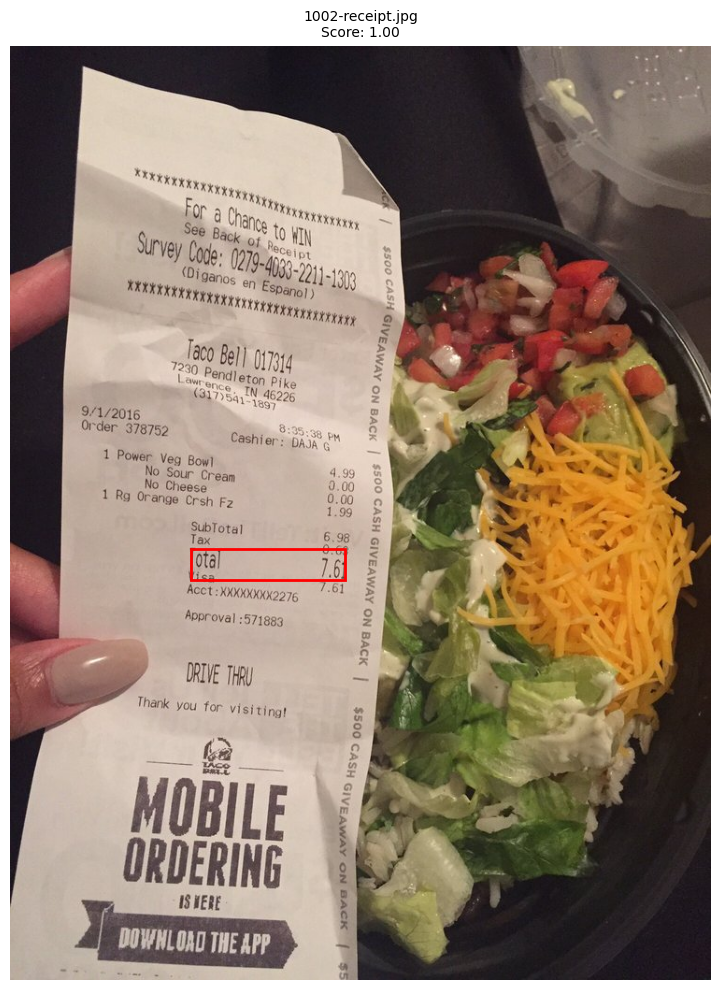

In [17]:
# ===== Load the Model and Processor =====
# Load the trained model and processor from the specified directory
model_dir = "./model_dataset_srd"
model = LayoutLMv3ForTokenClassification.from_pretrained(model_dir)  # Load the trained model
processor = AutoProcessor.from_pretrained(model_dir)  # Load the processor for pre-processing OCR data

# Set the model to evaluation mode and move it to the appropriate device (GPU or CPU)
model.to(device)
model.eval()

# ===== Function to Predict "Total" from a Single Image =====
def predict_total(image_path):
    """
    Predict the bounding box for the "total" and its associated value in a receipt image.

    Args:
        image_path (str): Path to the receipt image.

    Returns:
        list: Combined bounding boxes for "total" and associated values.
        list: Confidence scores for the predictions.
        Image: The original receipt image.
    """
    # Load and preprocess the receipt image
    image = Image.open(image_path).convert("RGB")
    
    # Perform OCR to extract words and bounding boxes
    words, boxes, _ = run_ocr(image_path)
    width, height = image.size

    # Normalize bounding boxes to fit the 0-1000 range expected by the model
    normalized_boxes = [
        [
            int((box[0] / width) * 1000),
            int((box[1] / height) * 1000),
            int((box[2] / width) * 1000),
            int((box[3] / height) * 1000),
        ]
        for box in boxes
    ]

    # Encode the image, OCR words, and bounding boxes for the model
    encoding = processor(
        image,
        words,
        boxes=normalized_boxes,
        truncation=True,
        padding="max_length",
        max_length=512,
        return_tensors="pt",
    ).to(device)

    # Perform inference with the trained model
    with torch.no_grad():
        outputs = model(
            input_ids=encoding["input_ids"],
            attention_mask=encoding["attention_mask"],
            bbox=encoding["bbox"],
            pixel_values=encoding["pixel_values"],
        )

    # Get predictions and confidence scores for each token
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1).cpu().numpy()[0]  # Predicted labels for tokens
    confidences = torch.softmax(logits, dim=-1).cpu().numpy()[0]  # Confidence scores for each label

    # Identify "total" keywords and combine bounding boxes for the keyword and its value
    total_keywords = ["total", "total:", "total_due", "amount_due"]
    combined_boxes = []  # Stores combined bounding boxes for "total" and its value
    scores = []  # Stores confidence scores for the predictions

    for idx, word in enumerate(words):
        if predictions[idx] == 1 and any(keyword in word.lower() for keyword in total_keywords):
            if idx + 1 < len(words) and words[idx + 1].replace('.', '', 1).isdigit():
                # Combine bounding boxes for "total" and the associated numeric value
                x1 = min(boxes[idx][0], boxes[idx + 1][0])
                y1 = min(boxes[idx][1], boxes[idx + 1][1])
                x2 = max(boxes[idx][2], boxes[idx + 1][2])
                y2 = max(boxes[idx][3], boxes[idx + 1][3])
                combined_boxes.append([x1, y1, x2, y2])
                scores.append(confidences[idx, 1])  # Store the confidence score for "total"

    return combined_boxes, scores, image

# ===== Function to Evaluate the Model on the Test Dataset =====
def evaluate_best_predictions(image_dir, top_k=4):
    """
    Evaluate the model on the test dataset and extract the top predictions based on confidence scores.

    Args:
        image_dir (str): Directory containing test images.
        top_k (int): Number of top predictions to display.

    Returns:
        list: Top predictions, each containing score, bounding box, and the associated image.
    """
    all_results = []  # To store predictions for all test images
    image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".jpg")])

    # Process each image in the test dataset
    for image_path in tqdm(image_files, desc="Evaluating images"):
        combined_boxes, scores, image = predict_total(image_path)
        for box, score in zip(combined_boxes, scores):
            all_results.append((score, box, image, image_path))

    # Sort predictions by confidence score in descending order and return the top_k predictions
    all_results.sort(reverse=True, key=lambda x: x[0])
    return all_results[:top_k]

# ===== Function to Display Predictions on Images =====
def display_best_predictions(best_predictions):
    """
    Display the top predictions with bounding boxes on the corresponding receipt images.

    Args:
        best_predictions (list): List of top predictions, each containing score, bounding box, and image.
    """
    # Create a figure with one subplot per prediction
    fig, axes = plt.subplots(1, len(best_predictions), figsize=(20, 10))

    # Handle cases where there is only one prediction
    if len(best_predictions) == 1:
        axes = [axes]

    for i, (score, box, image, image_path) in enumerate(best_predictions):
        ax = axes[i]
        ax.imshow(image)
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor="red", facecolor="none")
        ax.add_patch(rect)
        ax.set_title(f"{os.path.basename(image_path)}\nScore: {score:.2f}", fontsize=10)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# ===== Test the Model =====
best_predictions = evaluate_best_predictions(image_dir, top_k=4)  # Evaluate the model on test data
display_best_predictions(best_predictions)  # Visualize the best predictions


## Testing the Model with the First Dataset Images

I evaluate the model using the images from the first dataset. The model processes the images, predicts the "total" and its associated value, and visualizes the top predictions with bounding boxes on the corresponding receipt images.


Evaluating images: 100%|██████████| 93/93 [01:32<00:00,  1.00it/s]


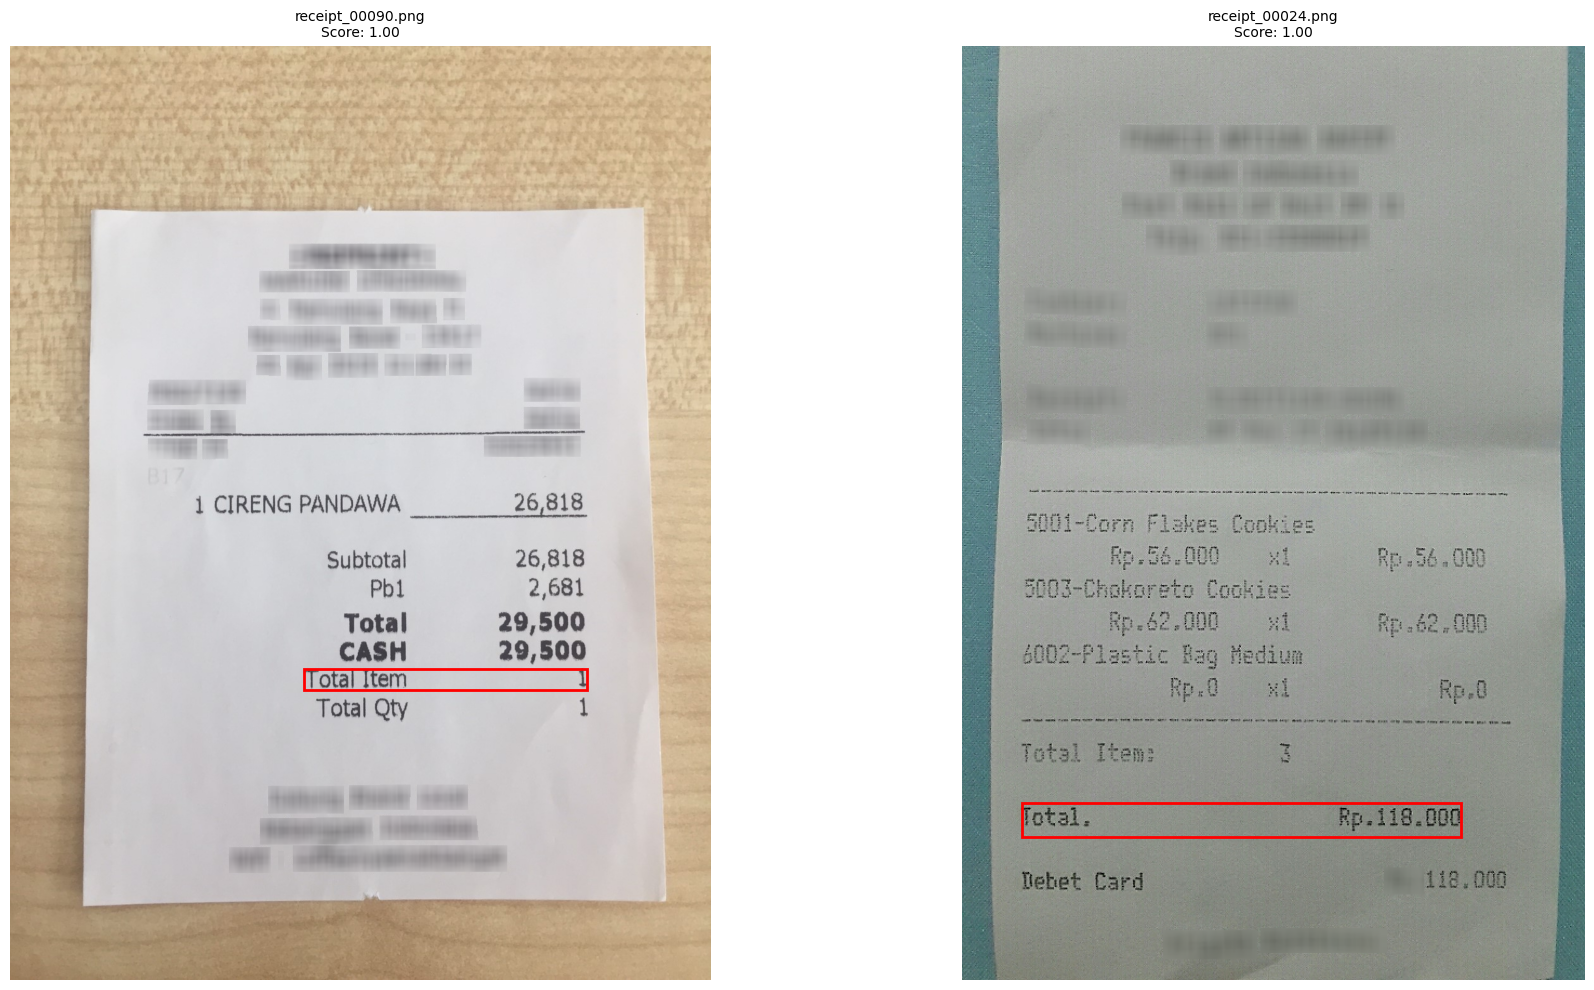

In [18]:
model.to(device)
model.eval()

# ===== OCR Function =====
def run_ocr(image_path):
    """
    Perform OCR on the receipt image to extract words and bounding boxes.

    Args:
        image_path (str): Path to the image file.

    Returns:
        tuple: A list of words, bounding boxes, and the image object.
    """
    image = Image.open(image_path).convert("RGB")
    ocr_data = pytesseract.image_to_data(image, output_type=Output.DICT)
    words, boxes = [], []
    for i, text in enumerate(ocr_data["text"]):
        if text.strip():  # Skip empty texts
            words.append(text.strip())
            x, y, w, h = ocr_data["left"][i], ocr_data["top"][i], ocr_data["width"][i], ocr_data["height"][i]
            boxes.append([x, y, x + w, y + h])  # Format: [x1, y1, x2, y2]
    return words, boxes, image

# ===== Image Preprocessing =====
def preprocess_image(image):
    """
    Preprocess the image to enhance OCR accuracy.

    Args:
        image (PIL.Image): Input image.

    Returns:
        PIL.Image: Preprocessed binary image.
    """
    # Convert image to grayscale
    gray_image = ImageOps.grayscale(image)
    # Apply binary thresholding
    binary_image = gray_image.point(lambda x: 0 if x < 128 else 255, '1')
    return binary_image

# ===== Prediction Function =====
def predict_total(image_path):
    """
    Predict the bounding boxes and scores for "total" values in the receipt image.

    Args:
        image_path (str): Path to the receipt image.

    Returns:
        list: Combined bounding boxes for "total" values and associated numbers.
        list: Confidence scores for the predictions.
        PIL.Image: The original image.
    """
    image = Image.open(image_path)
    image = preprocess_image(image)  # Preprocess the image

    # Perform OCR
    words, boxes, image = run_ocr(image_path)
    if not words:
        return [], [], image

    # Normalize bounding boxes to the 0-1000 range
    width, height = image.size
    normalized_boxes = [
        [
            int((box[0] / width) * 1000),
            int((box[1] / height) * 1000),
            int((box[2] / width) * 1000),
            int((box[3] / height) * 1000),
        ]
        for box in boxes
    ]

    # Encode the inputs for the model
    encoding = processor(
        image,
        words,
        boxes=normalized_boxes,
        truncation=True,
        padding="max_length",
        max_length=512,
        return_tensors="pt",
    ).to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(
            input_ids=encoding["input_ids"],
            attention_mask=encoding["attention_mask"],
            bbox=encoding["bbox"],
            pixel_values=encoding["pixel_values"],
        )

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1).cpu().numpy()[0]
    confidences = torch.softmax(logits, dim=-1).cpu().numpy()[0]

    # Identify bounding boxes and confidence scores for "TOTAL"
    total_keywords = ["total", "grand total", "montant", "total_due"]
    combined_boxes = []
    scores = []

    for idx, word in enumerate(words):
        if predictions[idx] == 1 and any(keyword in word.lower() for keyword in total_keywords):
            # Look for associated amounts
            for offset in range(1, 5):  # Check up to 5 words after
                if idx + offset < len(words) and words[idx + offset].replace(",", "").replace(".", "").isdigit():
                    x1 = min(boxes[idx][0], boxes[idx + offset][0])
                    y1 = min(boxes[idx][1], boxes[idx + offset][1])
                    x2 = max(boxes[idx][2], boxes[idx + offset][2])
                    y2 = max(boxes[idx][3], boxes[idx + offset][3])
                    combined_boxes.append([x1, y1, x2, y2])
                    scores.append(confidences[idx, 1])
                    break

    return combined_boxes, scores, image

# ===== Evaluate Predictions on Dataset =====
def evaluate_best_predictions(image_dir, top_k=4):
    """
    Evaluate the model on a dataset and extract the top predictions based on confidence scores.

    Args:
        image_dir (str): Directory containing receipt images.
        top_k (int): Number of top predictions to display.

    Returns:
        list: Top predictions, each containing score, bounding box, and associated image.
    """
    all_results = []
    image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith((".jpg", ".png", ".jpeg"))])

    for image_path in tqdm(image_files, desc="Evaluating images"):
        combined_boxes, scores, image = predict_total(image_path)
        for box, score in zip(combined_boxes, scores):
            all_results.append((score, box, image, image_path))

    # Sort by confidence score in descending order
    all_results.sort(reverse=True, key=lambda x: x[0])
    return all_results[:top_k]

# ===== Display Best Predictions =====
def display_best_predictions(best_predictions):
    """
    Display the top predictions with bounding boxes on the corresponding receipt images.

    Args:
        best_predictions (list): List of top predictions, each containing score, bounding box, and image.
    """
    if not best_predictions:
        print("No predictions found.")
        return

    fig, axes = plt.subplots(1, len(best_predictions), figsize=(20, 10))

    if len(best_predictions) == 1:
        axes = [axes]

    for i, (score, box, image, image_path) in enumerate(best_predictions):
        ax = axes[i]
        ax.imshow(image)
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor="red", facecolor="none")
        ax.add_patch(rect)
        ax.set_title(f"{os.path.basename(image_path)}\nScore: {score:.2f}", fontsize=10)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# ===== Test the Model with the First Dataset =====
image_dir = "./dataset/CORD/test/image"
best_predictions = evaluate_best_predictions(image_dir, top_k=4)
display_best_predictions(best_predictions)

## Observation

The second model performs significantly better on a different dataset due to the manual generation of OCR annotations. This tailored approach ensures the model adapts more effectively to the unique structure and characteristics of a new dataset.

## Conclusion

In this project, we explored and analyzed two receipt datasets to extract key information, such as total amounts, using advanced models like LayoutLMv3. Here is a summary of the key steps and outcomes:

1. **First Dataset (CORD)**:
   - This dataset was well-structured with pre-annotated data, allowing us to efficiently prepare and train a model capable of extracting relevant information.
   - The model was trained effectively, achieving impressive performance (precision and F1-score around 98%). This demonstrates the model’s ability to understand the dataset’s structure and information.

2. **Second Dataset (ExpressExpense)**:
   - This dataset lacked annotations, making it challenging to use directly with the model. We implemented an OCR-based approach to generate annotations.
   - After preparing new annotations, we trained a model on this dataset. The results showed that this strategy works well but is slightly less effective than with the first dataset due to less standardized data.

3. **Challenges Encountered**:
   - The model trained on the first dataset struggled to adapt to the second dataset because of differences in receipt structures.
   - The quality of annotations (automatic in the case of the second dataset) also impacted the results.

4. **Possible Improvements**:
   - Combining multiple datasets or collecting more data to make the model more versatile.
   - Enhancing the automatic annotation method to better capture receipt information.

In conclusion, this project demonstrated that it is possible to automate the extraction of key information from receipts using advanced models. However, it is essential to ensure that the data used is well-suited and carefully annotated.